<a href="https://colab.research.google.com/github/profdv004/Quantum-Fourier-Transform/blob/main/QFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Required Packages


In [1]:
!pip install qiskit
from IPython.display import clear_output
clear_output()

In [2]:
!pip install pylatexenc
clear_output()

In [3]:
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
IBMQ.save_account("45e18076a2b9a3026644e6efe76dcda789b4fc542afc2bab76c5c9675cb506c0b0d4c7cb966122f09490456b01c11ef64338581cb934ad0e452bd6da1701fde1")
provider = IBMQ.load_account()

configrc.store_credentials:WARNING:2020-12-03 06:30:45,350: Credentials already present. Set overwrite=True to overwrite.
/usr/local/lib/python3.6/dist-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


General QFT Function

In [4]:
def qft_rotations(circuit, n):
    if n == 0: # Exit function if circuit is empty
        return circuit
    n -= 1 # Indexes start from 0
    circuit.h(n) # Apply the H-gate to the most significant qubit
    for qubit in range(n):
        # For each less significant qubit, we need to do a
        # smaller-angled controlled rotation: 
        circuit.cu1(pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)

In [5]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

Now encoding 5 in fourier basis (where 5 in binary is 101)

In [6]:
qc = QuantumCircuit(3)

# Encode the state 5
qc.x(0)
qc.x(2)
qc.draw('text')

┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘

Visualising in Bloch Sphere


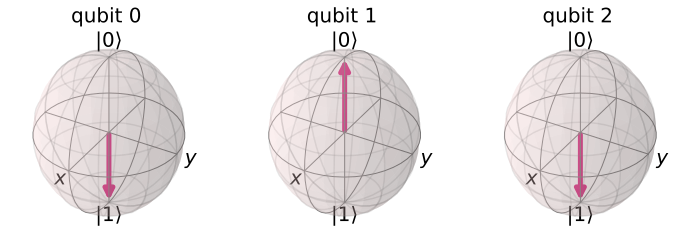

In [7]:
backend = Aer.get_backend("statevector_simulator")
statevector = execute(qc, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

Applying QFT

In [8]:
qft(qc,3)
qc.draw('text')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  if __name__ == '__main__':


┌───┐                 ┌───┐            ┌───┐   
q_0: ┤ X ├──────■─────■────┤ H ├───────■────┤ H ├─X─
     ├───┤      │     │π/2 └───┘ ┌───┐ │π/2 └───┘ │ 
q_1: ┤ H ├──────┼─────■─────■────┤ H ├─■──────────┼─
     ├───┤┌───┐ │π/4        │π/2 └───┘            │ 
q_2: ┤ X ├┤ H ├─■───────────■─────────────────────X─
     └───┘└───┘

Visualising after QFT in Bloch Sphere

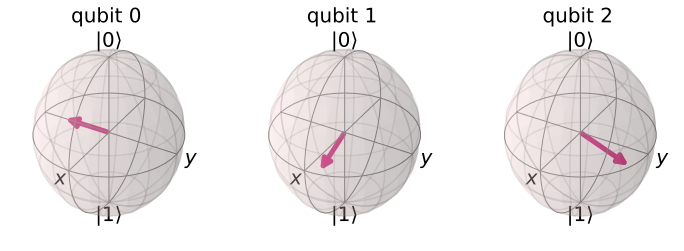

In [9]:
statevector = execute(qc, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)


Defining Inverse QFT

In [10]:
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit # .decompose() allows us to see the individual gates

Applying Inverse and measuring


In [11]:
nqubits=3
number=5
qc = inverse_qft(qc,3)
qc.measure_all()
qc.draw('text')

┌───┐                 ┌───┐            ┌───┐   ┌───────────────┐ ░ ┌─┐»
   q_0: ┤ X ├──────■─────■────┤ H ├───────■────┤ H ├─X─┤0              ├─░─┤M├»
        ├───┤      │     │π/2 └───┘ ┌───┐ │π/2 └───┘ │ │               │ ░ └╥┘»
   q_1: ┤ H ├──────┼─────■─────■────┤ H ├─■──────────┼─┤1 circuit86_dg ├─░──╫─»
        ├───┤┌───┐ │π/4        │π/2 └───┘            │ │               │ ░  ║ »
   q_2: ┤ X ├┤ H ├─■───────────■─────────────────────X─┤2              ├─░──╫─»
        └───┘└───┘                                     └───────────────┘ ░  ║ »
meas: 3/════════════════════════════════════════════════════════════════════╩═»
                                                                            0 »
«              
«   q_0: ──────
«        ┌─┐   
«   q_1: ┤M├───
«        └╥┘┌─┐
«   q_2: ─╫─┤M├
«         ║ └╥┘
«meas: 3/═╩══╩═
«         1  2

In [12]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to nqubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = Aer.get_backend('qasm_simulator')

/usr/local/lib/python3.6/dist-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2020-12-03 06:30:49,474: Credentials are already in use. The existing account in the session will be replaced.


In [13]:
job = execute(qc, backend=backend, shots=2000, seed_simulator=12345, backend_options={"fusion_enable":True})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.
  """Entry point for launching an IPython kernel.


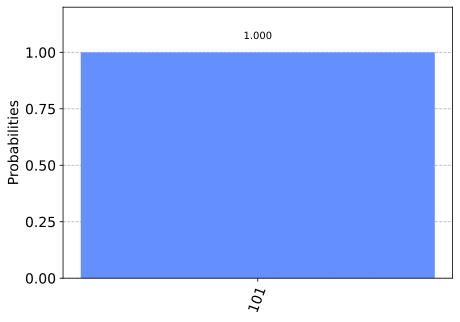

In [14]:
counts = job.result().get_counts()
plot_histogram(counts)


We see that the max count is for 101 and hence we have succsfully applied QFT and inverse QFT